In [547]:
import numpy as np
import matplotlib.pyplot as plt
from tools import *
from tp3_etu import *
from math import *
import time

In [548]:
def plot_frontiere(data,f,step=40):
    """ Trace un graphe de la frontiere de decision de f
    :param data: donnees
    :param f: fonction de decision
    :param step: pas de la grille
    :return:
    """
    grid,x,y=make_grid(data=data,step=step)

    plt.contourf(x,y,f(grid).reshape(x.shape),256)

def make_grid(data=None,xmin=-5,xmax=5,ymin=-5,ymax=5,step=40):
    """ Cree une grille sous forme de matrice 2d de la liste des points
    :param data: pour calcluler les bornes du graphe
    :param xmin: si pas data, alors bornes du graphe
    :param xmax:
    :param ymin:
    :param ymax:
    :param step: pas de la grille
    :return: une matrice 2d contenant les points de la grille
    """
    if data is not None:
        xmax, xmin, ymax, ymin = np.max(data[:,0]),  np.min(data[:,0]), np.max(data[:,1]), np.min(data[:,1])
    x, y =np.meshgrid(np.arange(xmin,xmax,(xmax-xmin)*1./step), np.arange(ymin,ymax,(ymax-ymin)*1./step))
    grid=np.c_[x.ravel(),y.ravel()]
    return grid, x, y

In [549]:
def projection(data):
    return np.hstack((np.ones((data.shape[0], 1)), data))

class Perceptron:
    def __init__(self,max_iter = 1000,eps=1e-3, projection = projection, bool_print = True):
        self.max_iter = max_iter
        self.eps = eps
        self.projection = projection or (lambda x: x) #projection fonction identite par default
        self.bool_print = bool_print
        
    def fit(self, data, y):        
        data = self.projection(data)
        self.w = np.random.random((1,data.shape[1]))
        self.histo_w  = np.zeros((self.max_iter,data.shape[1]))
        self.histo_f = np.zeros((self.max_iter,1))

        ylab=set(y.flat)

        if len(ylab)!=2:
            print("pas bon nombres de labels (%d)" % (ylab,))
            return
        self.labels = {-1: min(ylab), 1:max(ylab)}
        
        #Transformation de y suivant les labels
        y = 2*(y!=self.labels[-1])-1
        i=0
        while i<self.max_iter:
            idx = range(len(data))
            for j in idx:
                loss = self.loss_g(data[j],y[j:(j+1)])
                self.w = self.w - self.get_eps()*loss
                
            self.histo_w[i]=self.w
            self.histo_f[i]=self.loss(data,y)
            if self.bool_print:
                if i % (self.max_iter/10)==0: print(i,self.histo_f[i])
            i+=1
            
            
    def predict(self,data):
        data = self.projection(data)

        return np.array([self.labels[x] for x in np.sign(data.dot(self.w.T)).flat]).reshape((len(data),))
    
    def score(self,data,y):
        return np.mean(self.predict(data)==y)
    
    def get_eps(self):
        return self.eps
    
    def loss(self,data,y):
        return hinge(self.w,data,y)
    
    def loss_g(self,data,y):
        return grad_hinge(self.w,data,y)



In [550]:
def hinge(w, data, y):
    data, y, w = data.reshape(len(y),-1), y.reshape(-1,1), w.reshape(1,-1)
    X = data
    return  (np.maximum(0, - y*X.dot(w.T))).mean()

def grad_hinge(w, data, y):
    data, y, w = data.reshape(len(y),-1), y.reshape(-1,1), w.reshape(1,-1)
    
    X = data
    
    gra = (np.maximum(0, - y*X.dot(w.T))*(-y*X)).mean(axis = 0)
    return gra


## Test sur les données à deux gaussiennes

In [277]:
xtrain, ytrain = gen_arti(2, 2, 1, 1000, 0, 0.02)
xtest, ytest = gen_arti(2, 2, 1, 300, 0, 0.02)

P = Perceptron(max_iter = 1000, projection= projection)
P.fit(xtrain, ytrain)


0 [ 0.00260088]
100 [ 0.00093906]
200 [ 0.00053369]
300 [ 0.0003185]
400 [ 0.00020573]
500 [ 0.00013951]
600 [ 0.00012462]
700 [ 0.00012167]
800 [ 0.00011859]
900 [ 0.00011935]


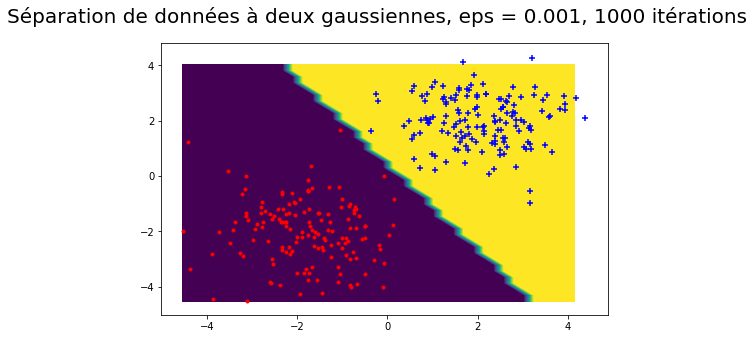

Score : 1.0


In [278]:
plt.figure(figsize=(8,5))
plt.suptitle("Séparation de données à deux gaussiennes, eps = 0.001, 1000 itérations", fontsize = 20)

plot_frontiere(xtest, P.predict)
plot_data(xtest, ytest)

plt.show()
print("Score : {}".format(P.score(xtest, ytest)))

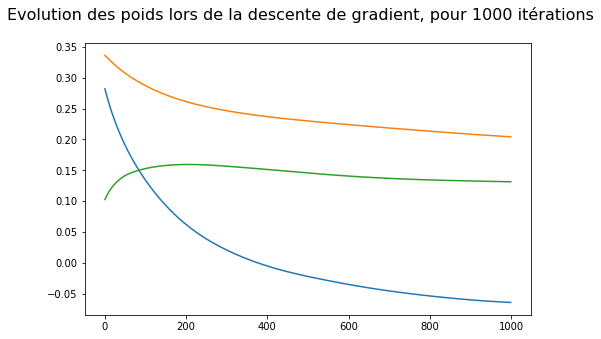

In [281]:
plt.figure(figsize=(8,5))

plt.plot(np.arange(1000), P.histo_w)
plt.suptitle("Evolution des poids lors de la descente de gradient, pour 1000 itérations", fontsize = 16)
plt.xtitle()
plt.show()

<p> Les données étant ici linéairement séparables, la solution trouvée n'est pas unique puisqu'il existe une infinité de droite séparant les données. </p>
<p> La frontière est pertinente, elle sépare parfaitement les données. </p>

## Données bruitées

In [551]:
xtrain, ytrain = gen_arti(1, 2, 0.5, 1000, 1, 0.02)
xtest, ytest = gen_arti(1, 2, 0.5, 1000, 1, 0.02)

P = Perceptron(max_iter = 300, projection= projection, bool_print = False)
P.fit(xtrain, ytrain)


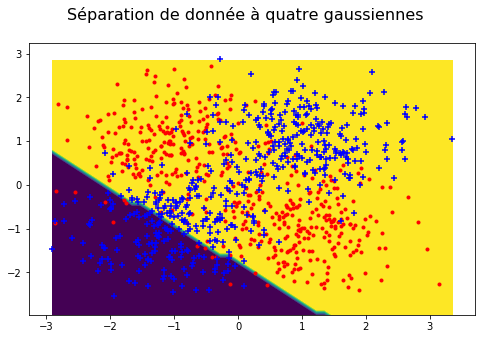

Score:  0.39


In [553]:
plt.figure(figsize=(8,5))

plt.suptitle("Séparation de donnée à quatre gaussiennes", fontsize = 16)
plot_frontiere(xtrain, P.predict, 50)
plot_data(xtest,ytest)
plt.show()
print("Score: ", P.score(xtest, ytest))

Pour des données non linéairement séparables, la frontière n'est pas pertinente.

## Question 1.4 : Variante de descente de gradient

In [557]:
class Perceptron_variante(Perceptron):
    def __init__(self, max_iter = 200, eps=1e-3, projection = projection, bool_print = True, var = "", k = 10):
        Perceptron.__init__(self, max_iter, eps, projection, bool_print)
        self.var = var
        self.k = k
        
    def fit(self, data, y):        
        data = self.projection(data)
        self.w = np.random.random((1,data.shape[1]))
        self.histo_w  = np.zeros((self.max_iter,data.shape[1]))
        self.histo_f = np.zeros((self.max_iter,1))

        ylab=set(y.flat)

        if len(ylab)!=2:
            print("pas bon nombres de labels (%d)" % (ylab,))
            return
        self.labels = {-1: min(ylab), 1:max(ylab)}
        
        #Transformation de y suivant les labels
        y = 2*(y!=self.labels[-1])-1
        i=0
        while i<self.max_iter:
            
            # Choix de la descente de gradiant
            if (self.var == "stoch"):
                idx = np.arange(len(data))
                idx = np.random.permutation(idx)    
                for j in idx:
                    loss = self.loss_g(data[j],y[j:(j+1)])
                    self.w = self.w - self.get_eps()*loss
            
            elif (self.var == "batch"):
                idx = range(len(data))
                loss_mean = self.loss_g(data[idx],y[idx]).mean()
                self.w = self.w - self.get_eps()*loss_mean
            
            elif (self.var == "minibatch"):
                idx = np.arange(len(data))
                idx = np.random.permutation(idx)
                n = len(idx)
                tranches = [idx[i*(n//self.k): (i+1)*(n//self.k)] for i in range (self.k)]
                for t in tranches:
                    loss_mean = self.loss_g(data[t],y[t]).mean()
                    self.w = self.w - self.get_eps()*loss_mean
                 
            else:
                # On retombe sur la descente de gradient standard
                idx = range(len(data))
                for j in idx:
                    loss = self.loss_g(data[j],y[j:(j+1)])
                    self.w = self.w - self.get_eps()*loss

                
            self.histo_w[i]=self.w
            self.histo_f[i]=self.loss(data,y)
            if self.bool_print:
                if i % (self.max_iter/10)==0: print(i,self.histo_f[i])
            i+=1
            

In [560]:
xtrain, ytrain = gen_arti(1, 2, 0.2, 1000, 0, 0.02)
xtest, ytest = gen_arti(1, 2, 0.2, 1000, 0, 0.02)

Pstandard = Perceptron_variante(eps = 0.1, max_iter = 200, bool_print=False)
Pstoch = Perceptron_variante(var = "stoch", eps = 0.1, max_iter = 200, bool_print=False)
Pbatch = Perceptron_variante(var = "batch", eps = 0.1, max_iter = 200, bool_print=False)
Pmbatch= Perceptron_variante(var = "minibatch", eps = 0.1, max_iter = 200, bool_print=False, k= 50)


t1 = time.time()
Pstandard.fit(xtrain, ytrain)
time_standard = time.time() - t1

t2 = time.time()
Pstoch.fit(xtrain, ytrain)
time_stoch = time.time() - t2

t3 = time.time()
Pbatch.fit(xtrain, ytrain)
time_batch = time.time() - t3

t4 = time.time()
Pmbatch.fit(xtrain, ytrain)
time_mbatch = time.time() - t4


<h4> Temps d'exécution de chaque descente de gradient (pour 200 passes): </h4>

In [555]:
print("   Descente standard: ", time_standard, " secondes")
print("   Descente stochastique: ", time_stoch, " secondes")
print("   Descente batch: ", time_batch, " secondes")
print("   Descente mini-batch (k = 50): ", time_mbatch, " secondes")

   Descente standard:  5.407630920410156  secondes
   Descente stochastique:  5.313200950622559  secondes
   Descente batch:  0.0810689926147461  secondes
   Descente mini-batch (k = 50):  0.42243385314941406  secondes


<h3> Observations </h3>
<p> La <b>descente batch est bien plus rapide que la descente standarde ou stochastique</b>, et <b>la descente mini-batch est entre les deux</b> en se rapprochant de la vitesse de batch ou stochastique suivant si k tend vers 1 ou N respectivement.</p>

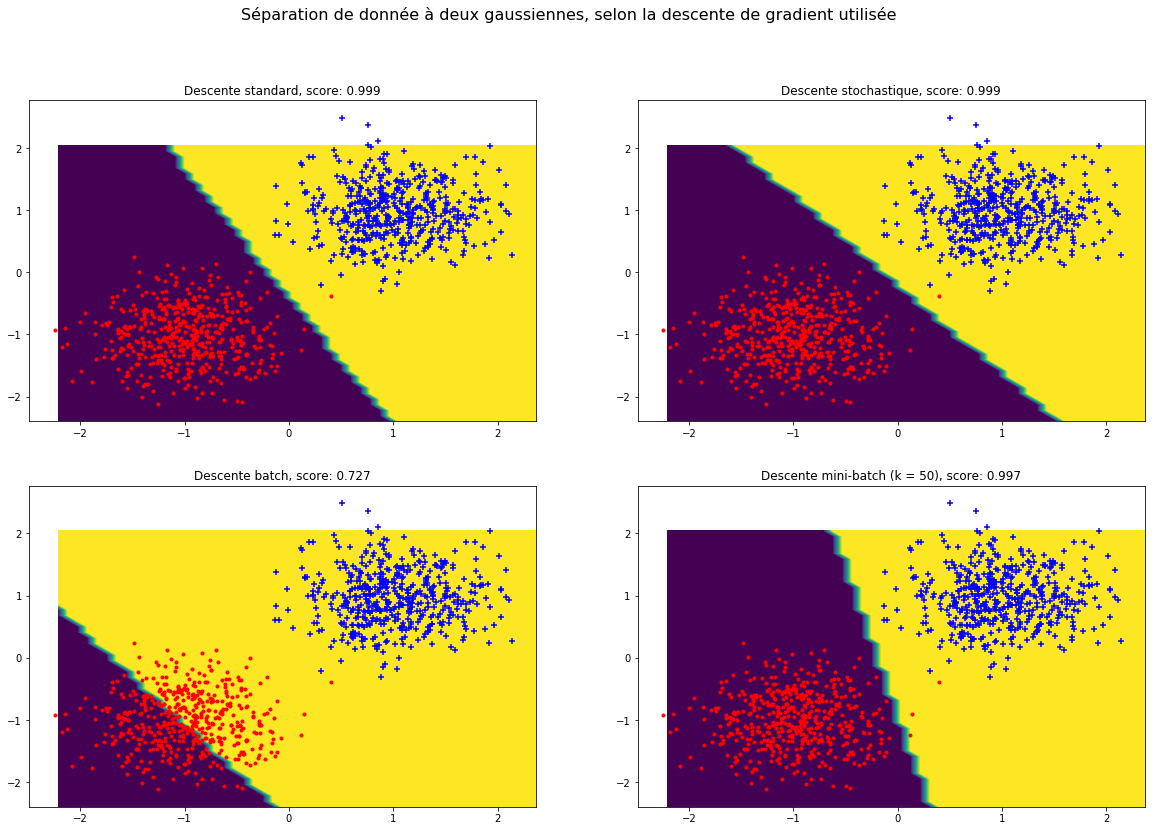

In [561]:
plt.figure(figsize=(20,13))

plt.suptitle("Séparation de donnée à deux gaussiennes, selon la descente de gradient utilisée", fontsize = 16)

plt.subplot(2, 2, 1)
plot_frontiere(xtrain, Pstandard.predict, 50)
plot_data(xtest,ytest)
plt.title("Descente standard, score: {}".format(Pstandard.score(xtest, ytest)))

plt.subplot(2, 2, 2)
plot_frontiere(xtrain, Pstoch.predict, 50)
plot_data(xtest,ytest)
plt.title("Descente stochastique, score: {}".format(Pstoch.score(xtest, ytest)))

plt.subplot(2, 2, 3)
plot_frontiere(xtrain, Pbatch.predict, 50)
plot_data(xtest,ytest)
plt.title("Descente batch, score: {}".format(Pbatch.score(xtest, ytest)))

plt.subplot(2, 2, 4)
plot_frontiere(xtrain, Pmbatch.predict, 50)
plot_data(xtest,ytest)
plt.title("Descente mini-batch (k = 50), score: {}".format(Pmbatch.score(xtest, ytest)))

plt.show()

Pour des données à peu près linéairement séparables, les quatre descentes conduisent à des résultats relativement similaires. Cependant la descente batch semble tomber plus facilement dans des minimas locaux, c'est la raison pour laquelle elle ne sépare pas bien les données lors de certaines exécutions.

<h3>Test de performance en fonction de $\sigma$ </h3>

In [488]:
Pstandard = Perceptron_variante(eps = 0.1, max_iter = 200, bool_print=False)
Pstoch = Perceptron_variante(var = "stoch", eps = 0.1, max_iter = 200, bool_print=False)
Pbatch = Perceptron_variante(var = "batch", eps = 0.1, max_iter = 200, bool_print=False)
Pmbatch= Perceptron_variante(var = "minibatch", eps = 0.1, max_iter = 200, bool_print=False, k= 100)

sigmas = np.linspace(0.08, 0.8, 5, endpoint= False)

score_standard = []
score_stoch = []
score_batch = []
score_mbatch = []

for sigma in sigmas:
    print(sigma)
    xtrain, ytrain = gen_arti(1, 2, sigma, 1000, 0, 0.02)
    xtest, ytest = gen_arti(1, 2, sigma, 1000, 0, 0.02)

    Pstandard.fit(xtrain, ytrain)
    Pstoch.fit(xtrain, ytrain)
    Pbatch.fit(xtrain, ytrain)
    Pmbatch.fit(xtrain, ytrain)
    
    score_standard.append(Pstandard.score(xtest, ytest))
    score_stoch.append(Pstoch.score(xtest, ytest))
    score_batch.append(Pbatch.score(xtest, ytest))
    score_mbatch.append(Pmbatch.score(xtest, ytest))

0.08
0.224
0.368
0.512
0.656


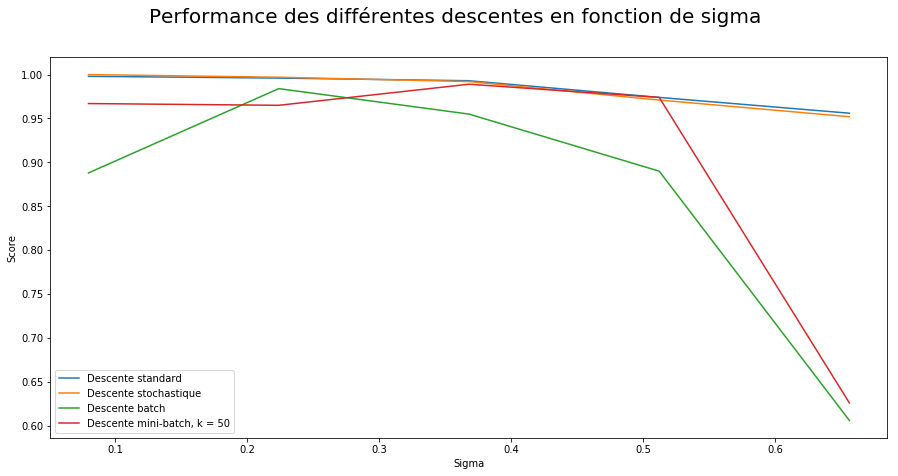

In [704]:
plt.figure(figsize=(15, 7))

plt.suptitle("Performance des différentes descentes en fonction de sigma", fontsize=20)
plt.plot(sigmas, score_standard, label = "Descente standard")
plt.plot(sigmas, score_stoch, label = "Descente stochastique")
plt.plot(sigmas, score_batch, label = "Descente batch")
plt.plot(sigmas, score_mbatch, label = "Descente mini-batch, k = 50")
plt.xlabel("Sigma")
plt.ylabel("Score")
plt.legend()
plt.show()

## Conclusions
<p>Les descentes <b>standards et stochastiques</b> montrent les meilleurs performances, mais sont bien moins rapides que la méthode <b>batch</b>. L'utilisation d'une méthode dépend donc d'un arbitrage entre la performance et le temps d'exécution. La descente <b>mini-batch</b> permet alors de balancer ces deux critère en jouant sur le noùbre $k$ de batchs.</p>

# Partie 2 : Données USPS

In [17]:
xuspstrain,yuspstrain = load_usps("USPS_train.txt")
xuspstest,yuspstest = load_usps("USPS_test.txt")

## Question 2.1

<h4> Entrainement 1 vs. 1 </h4>

In [657]:
def train_p(n1, n2, iter = 100):
    Pu = Perceptron(max_iter = iter, bool_print = False)
    xtrain,ytrain = get_usps([n1, n2], xuspstrain,yuspstrain)
    xtest,ytest = get_usps([n1, n2],xuspstest,yuspstest)

    Pu.fit(xtrain, ytrain)
    
    return Pu.score(xtest, ytest), Pu.w[0][1:]

In [658]:
s1, w1 = train_p(6, 9)
s2, w2 = train_p(1, 2)

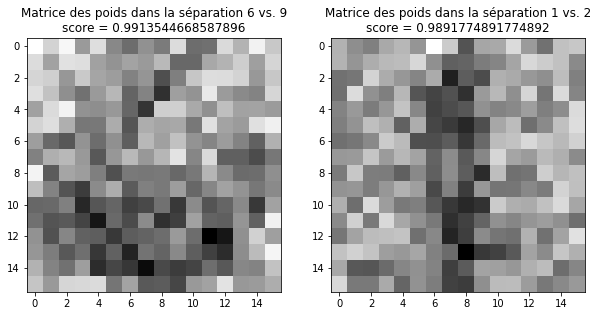

In [659]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Matrice des poids dans la séparation 6 vs. 9\nscore = {}".format(s1))
show_usps(w1)

plt.subplot(1, 2, 2)
plt.title("Matrice des poids dans la séparation 1 vs. 2\nscore = {}".format(s2))
show_usps(w2)

plt.show()


<h4> Entrainement 2 vs. 2 </h4>

In [672]:
n11, n12 = 1, 2
n21, n22 = 4, 7

xtrain,ytrain = get_usps([[n11, n12], [n21, n22]], xuspstrain, yuspstrain)
xtest,ytest = get_usps([[n11, n12], [n21, n22]], xuspstest, yuspstest)

label_train = np.linspace(-1, -1, len(ytrain), dtype=int)
label_train[ytrain == n11] = 1
label_train[ytrain == n12] = 1

label_test = np.linspace(-1, -1, len(ytest), dtype=int)
label_test[ytest == n11] = 1
label_test[ytest == n12] = 1

idx_train = np.random.permutation(range(len(ytrain)))
idx_test = np.random.permutation(range(len(ytest)))

data_train, label_train = xtrain[idx_train,:], label_train[idx_train]    
data_test, label_test = xtest[idx_test,:], label_test[idx_test]    

Pu = Perceptron(max_iter = 100, bool_print = False, eps = 0.001)
Pu.fit(data_train, label_train)

s, w = Pu.score(data_test, label_test), Pu.w[0][1:]

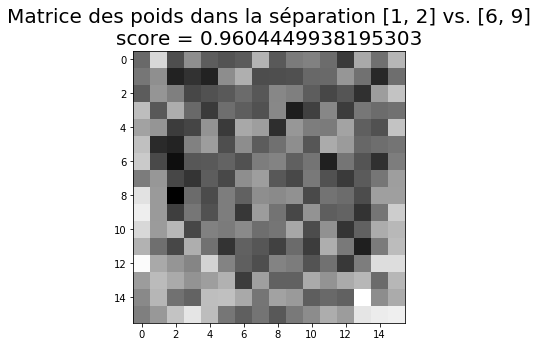

In [673]:
plt.figure(figsize=(10, 5))

plt.title("Matrice des poids dans la séparation [1, 2] vs. [6, 9]\nscore = {}".format(s), fontsize = 20)
show_usps(w)
plt.show()

<p> Le perceptron parvient à séparer les données avec d'excellents scores. </p>

# Question 2.2 : Courbes d'erreurs en apprentissage

## Test 1 vs. 1

In [519]:
def get_histo(n1, n2 = None, iter_min = 20, iter_max = 200, step = 20):
    if (type(n1) == list):
        xtrain,ytrain = get_usps_group_vs_rest(n1, xuspstrain, yuspstrain)
        xtest,ytest = get_usps_group_vs_rest(n1, xuspstest, yuspstest)
        
    elif (n2 == None):
        xtrain,ytrain = get_usps_one_against_all(n1, xuspstrain, yuspstrain)
        xtest,ytest = get_usps_one_against_all(n1, xuspstest, yuspstest)

    else:
        xtrain,ytrain = get_usps([n1, n2], xuspstrain, yuspstrain)
        xtest,ytest = get_usps([n1, n2], xuspstest, yuspstest)

    histo_train, histo_test = [], []

    iter = iter_min
    while(iter < iter_max):
        P = Perceptron(max_iter = iter, bool_print=False)
        
        P.fit(xtrain,ytrain)
        
        histo_train.append(P.score(xtrain,ytrain))
        histo_test.append(P.score(xtest,ytest))
        
        iter += step
        
    return histo_train, histo_test
        

In [538]:
iter_min, iter_max, step = 1, 200, 20
histo_train, histo_test = get_histo(4, 7, iter_min= iter_min, iter_max = iter_max, step = step)

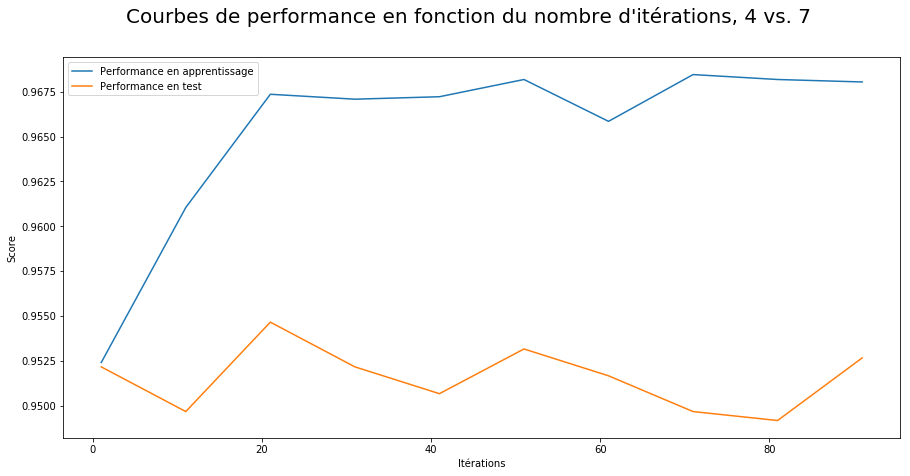

In [705]:
plt.figure(figsize=(15, 7))

plt.suptitle("Courbes de performance en fonction du nombre d'itérations, 4 vs. 7", fontsize = 20)
plt.plot(np.arange(iter_min, iter_max, step), histo_train, label = "Performance en apprentissage")
plt.plot(np.arange(iter_min, iter_max, step), histo_test, label = "Performance en test")
plt.xlabel("Itérations")
plt.ylabel("Score")

plt.legend()
plt.show()

## Test 1 chiffre contre tous

In [27]:
def get_usps_one_against_all(n, datax, datay):
    """ l : liste des chiffres a extraire"""
    data, label = get_usps([i for i in range (10)], datax, datay)
    label = np.where(label == n, 1, -1)
    label = label.reshape(-1, 1)


    tmpx,tmpy = np.vstack(data),np.hstack(label)
    idx = np.random.permutation(range(len(tmpy)))
    return tmpx[idx,:],tmpy[idx]    


In [572]:
iter_min, iter_max, step = 1, 100, 10
histo_train, histo_test = get_histo(4, iter_min= iter_min, iter_max = iter_max, step = step)

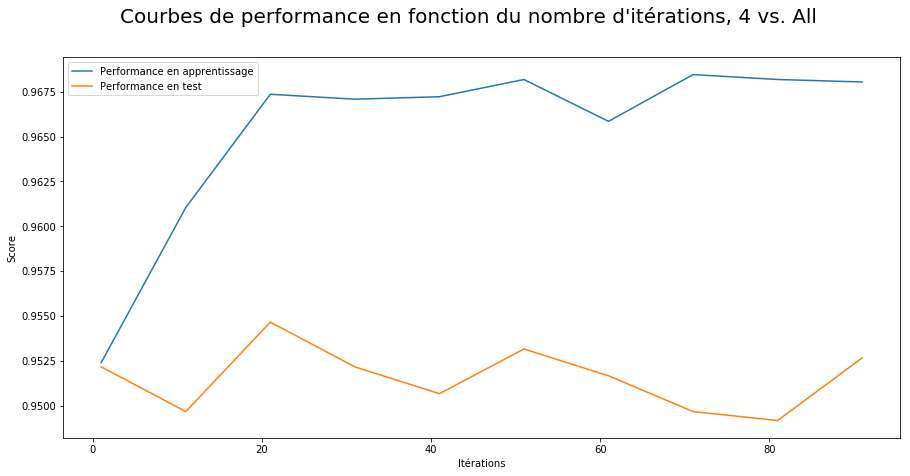

In [706]:
plt.figure(figsize=(15, 7))

plt.suptitle("Courbes de performance en fonction du nombre d'itérations, 4 vs. All", fontsize = 20)
plt.plot(np.arange(iter_min, iter_max, step), histo_train, label = "Performance en apprentissage")
plt.plot(np.arange(iter_min, iter_max, step), histo_test, label = "Performance en test")
plt.xlabel("Itérations")
plt.ylabel("Score")

plt.legend()
plt.show()


## Test un sous-ensemble contre un autre

In [32]:
def get_usps_group_vs_rest(group1, datax, datay):
    """ l : liste des chiffres a extraire"""
    data, label = get_usps([i for i in range (10)], datax, datay)
    label = np.where(np.in1d(label,group1), 1, -1)
    label = label.reshape(-1, 1)

    tmpx,tmpy = np.vstack(data),np.hstack(label)
    idx = np.random.permutation(range(len(tmpy)))
    
    return tmpx[idx,:],tmpy[idx]    


In [545]:
iter_min, iter_max, step = 1, 200, 20
histo_train, histo_test = get_histo([1, 2, 3, 4, 5], iter_min= iter_min, iter_max = iter_max, step = step)

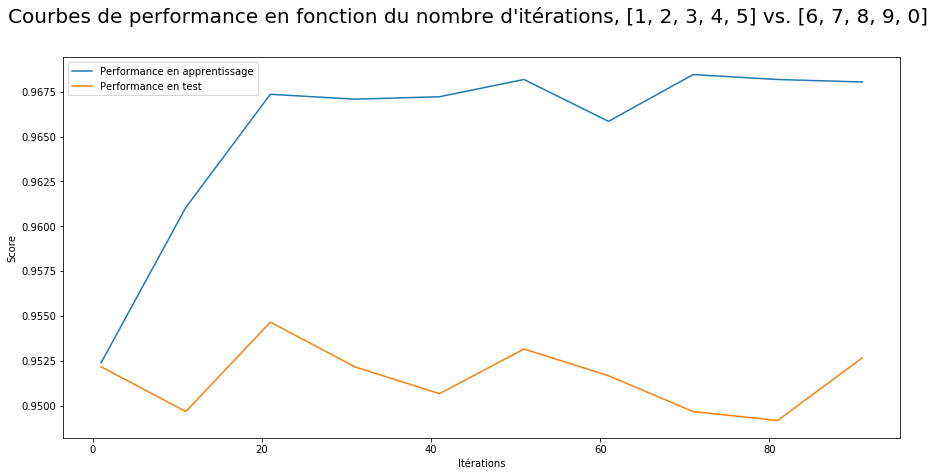

In [707]:
plt.figure(figsize=(15, 7))

plt.suptitle("Courbes de performance en fonction du nombre d'itérations, [1, 2, 3, 4, 5] vs. [6, 7, 8, 9, 0]", fontsize = 20)
plt.plot(np.arange(iter_min, iter_max, step), histo_train, label = "Performance en apprentissage")
plt.plot(np.arange(iter_min, iter_max, step), histo_test, label = "Performance en test")
plt.xlabel("Itérations")
plt.ylabel("Score")

plt.legend()
plt.show()

<p>On observe un léger sur-apprentissage. Un bon nombre d'itération pour chaque setting semble être:
<li> 1 vs. 1: environ 50 </li>
<li> 1 vs. All: environ 10-20 </li>
<li> Subset vs. Subset: environ 100 </li>
</p>


# Partie 3 : Expressivité et feature map

Avec le plongement polynomial $poly(x)=(1, x_1, x_2, x_1x_2, x_1^2, x_2^2)$, les frontières de décision devraient ressembler à des hyperboles.

In [677]:
def poly(data):
    proj = np.hstack((np.ones((data.shape[0], 1)), data))
    proj = np.hstack((proj, (data[:, 0]*data[:, 1]).reshape(-1, 1)))

    proj = np.hstack((proj, np.power(data, 2)))
    return proj

In [684]:
P = Perceptron(bool_print= False, max_iter= 200, projection= poly)

In [685]:
xtrain, ytrain = gen_arti(1, 2, 0.4, 1000, 1, 0.001)
xtest, ytest = gen_arti(1, 2, 0.4, 1000, 1, 0.001)

P.fit(xtrain, ytrain)

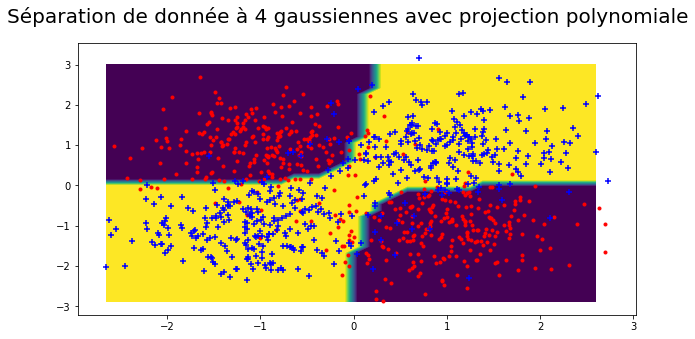

Score:  0.888


In [693]:
plt.figure(figsize=(10, 5))
plt.suptitle("Séparation de donnée à 4 gaussiennes avec projection polynomiale", fontsize = 20)
plot_frontiere(xtest, P.predict)
plot_data(xtest,ytest)
plt.show()
print("Score: ", P.score(xtest, ytest))

Le Perceptron parvient très bien à apprendre le mélange de 4 gaussiennes. Il ne parvient cependant pas à apprendre la distribution en échiquier.

## Plongement gaussien

<p>Considérons,pour l'ensemble de points $B = \{ o^i \in R^d \}^{N_b}_{i=1}$, l'espace projeté $gauss_B(x)=\left((k(x, o^1), k(x, o^2), \cdots, k(x, o^{N_b})\right)$ où $k(x, x') = e^{-\frac{\|x-x'\|^2}{2\sigma^2}}$. La i-ème dimension de l'espace projeté représente la similarité avec le i-ème point de l'ensemble $B$. Un valeur forte indique que $x$ est proche du point $o^i$, et à l'inverse une valeur faible indique que $x$ a peu de similarité avec $o^i$. </p>
Le poids $w^i$ représente alors combien $o^i$ est similaire au vecteur $x$.

In [41]:
def gaussian(x, data, sigma):
    x = np.abs((x-data)/sigma)
    if (len(x.shape) == 1):
        x = x.reshape(-1, 1)

    res = np.exp(-0.5*np.power(np.linalg.norm(x, axis = 1), 2))/((2*pi)**(len(x.shape)/2))
    return res

def proj_gauss(data, sigma = 0.5, O_tab = []):
    """Projection gaussienne sur les points de O_tab"""
    gauss = np.array([gaussian(o, data, sigma) for o in O_tab]).T
        
    return gauss



In [42]:
def extract_random(data, N):
    """Extrait aléatoirement N points de l'espace data"""
    idx = np.random.randint(0, data.shape[0], size = N)
    tab = data[idx]
    
    return tab

def extract_subset(data, N):
    """Extrait aléatoirement N points de l'espace data"""
    id_debut = np.random.randint(data.shape[0]-N)
    tab = data[id_debut: id_debut+N]
    return tab

# Test sur les données artificielles 
## Mélange de deux gaussiennes

In [182]:
xtrain, ytrain = gen_arti(1, 2, 0.3, 1000, 0, 0.02)
xtest, ytest = gen_arti(1, 2, 0.3, 1000, 0, 0.02)

O1 = extract_random(xtrain, 50)
proj_random = lambda x : proj_gauss(x, sigma = 0.5, O_tab = O1)
O2 = extract_subset(xtrain, 50)
proj_subset = lambda x : proj_gauss(x, sigma = 0.5, O_tab = O2)

P1 = Perceptron(bool_print= False, max_iter= 100, projection= proj_random, eps=0.1)
P2 = Perceptron(bool_print= False, max_iter= 100, projection= proj_subset, eps=0.1)
                       
P1.fit(xtrain, ytrain)
P2.fit(xtrain, ytrain)



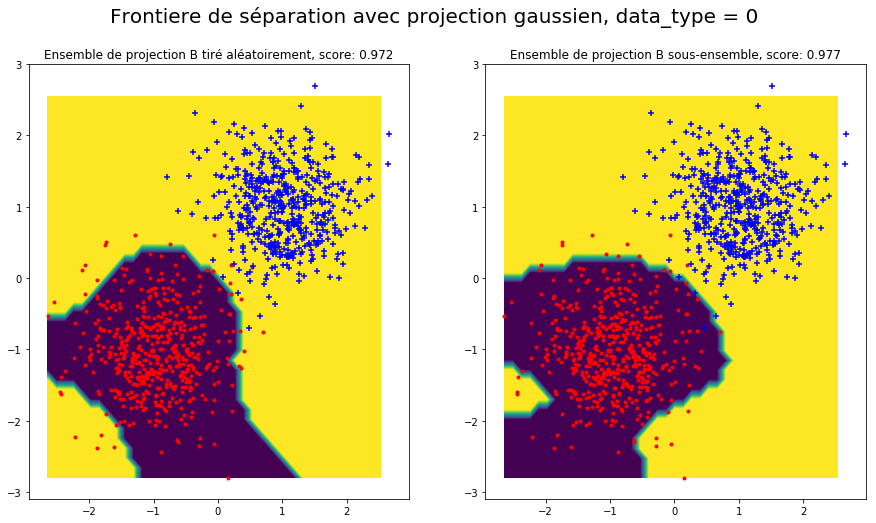

In [183]:
plt.figure(figsize= (15, 6))
plt.suptitle("Frontiere de séparation avec projection gaussien, data_type = 0", fontsize = 20)

plt.subplot(1, 2, 1)
plt.title("Ensemble de projection B tiré aléatoirement, score: {}".format(P1.score(xtest, ytest)))
plot_frontiere(xtest, P1.predict)
plot_data(xtest, ytest)

plt.subplot(1, 2, 2)
plt.title("Ensemble de projection B sous-ensemble, score: {}".format(P2.score(xtest, ytest)))
plot_frontiere(xtest, P2.predict)
plot_data(xtest, ytest)

plt.show()

## Mélange de quatre gaussiennes

In [200]:
xtrain, ytrain = gen_arti(1, 2, 0.2, 1000, 1, 0.02)
xtest, ytest = gen_arti(1, 2, 0.2, 1000, 1, 0.02)

O1 = extract_random(xtrain, 50)
proj_random = lambda x : proj_gauss(x, sigma = 0.5, O_tab = O1)
O2 = extract_subset(xtrain, 50)
proj_subset = lambda x : proj_gauss(x, sigma = 0.5, O_tab = O2)

P1 = Perceptron(bool_print= False, max_iter= 100, projection= proj_random, eps=0.1)
P2 = Perceptron(bool_print= False, max_iter= 100, projection= proj_subset, eps=0.1)
                       
P1.fit(xtrain, ytrain)
P2.fit(xtrain, ytrain)



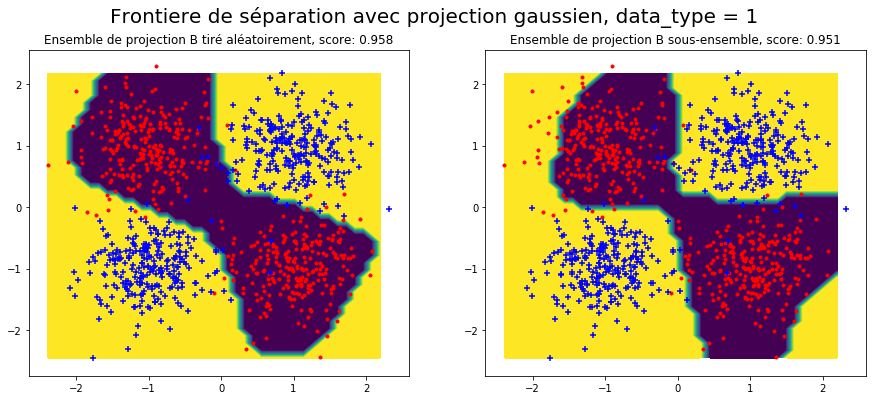

In [201]:
plt.figure(figsize= (15, 6))
plt.suptitle("Frontiere de séparation avec projection gaussien, data_type = 1", fontsize = 20)

plt.subplot(1, 2, 1)
plt.title("Ensemble de projection B tiré aléatoirement, score: {}".format(P1.score(xtest, ytest)))
plot_frontiere(xtest, P1.predict)
plot_data(xtest, ytest)

plt.subplot(1, 2, 2)
plt.title("Ensemble de projection B sous-ensemble, score: {}".format(P2.score(xtest, ytest)))
plot_frontiere(xtest, P2.predict)
plot_data(xtest, ytest)

plt.show()

## Echiquier

In [194]:
xtrain, ytrain = gen_arti(1, 2, 0.2, 2000, 2, 0.02)
xtest, ytest = gen_arti(1, 2, 0.2, 1000, 2, 0.02)

O1 = extract_random(xtrain, 500)
proj_random = lambda x : proj_gauss(x, sigma = 0.3, O_tab = O1)
O2 = extract_subset(xtrain, 500)
proj_subset = lambda x : proj_gauss(x, sigma = 0.3, O_tab = O2)

P1 = Perceptron(bool_print= False, max_iter= 200, projection= proj_random, eps=0.1)
P2 = Perceptron(bool_print= False, max_iter= 200, projection= proj_subset, eps=0.1)
                       
P1.fit(xtrain, ytrain)
P2.fit(xtrain, ytrain)



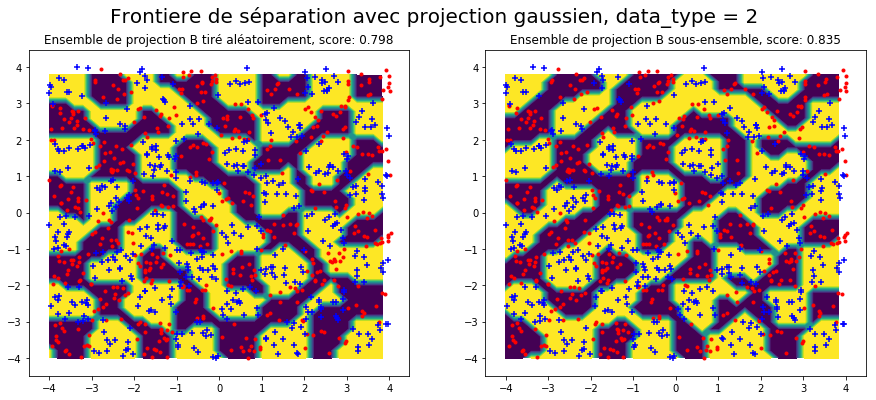

In [199]:
plt.figure(figsize= (15, 6))
plt.suptitle("Frontiere de séparation avec projection gaussien, data_type = 2", fontsize = 20)

plt.subplot(1, 2, 1)
plt.title("Ensemble de projection B tiré aléatoirement, score: {}".format(P1.score(xtest, ytest)))
plot_frontiere(xtest, P1.predict)
plot_data(xtest, ytest)

plt.subplot(1, 2, 2)
plt.title("Ensemble de projection B sous-ensemble, score: {}".format(P2.score(xtest, ytest)))
plot_frontiere(xtest, P2.predict)
plot_data(xtest, ytest)

plt.show()

# Question 3.4

<p>Ce modèle est beaucoup plus maléable que le modèle linéaire : il permet d'obtenir de très bon résultats même si la fonction séparant les données est très complexe. 
<p> Plus $w$ a un nombre élevé de dimensions nulles, moins le modèle sera expressif car il aura moins de points sur lesquels s'appuyer. </p>

<p> Rajouter un terme de pénalisation sur la norme du vecteur de poids permet de régulariser le modèle: on évite par exemple où deux gaussiennes se compensent. </p>

In [67]:
def hinge_punished(w, data, y, lambd = 1):
    data, y, w = data.reshape(len(y),-1), y.reshape(-1,1), w.reshape(1,-1)
    X = data
    return  (np.maximum(0, - y*X.dot(w.T))).mean() + lambd*(w.dot(w.T))

def grad_hinge_punished(w,data, y, lambd = 1):
    data, y, w = data.reshape(len(y),-1), y.reshape(-1,1), w.reshape(1,-1)
    
    X = data
    
    gra = (np.maximum(0, - y*X.dot(w.T))*(-y*X)).mean(axis = 0)
    return gra

In [68]:
class Perceptron_punish(Perceptron):
    def __init__(self, max_iter = 200, eps=1e-3, projection = projection, bool_print = True, lambd = 1):
        Perceptron.__init__(self, max_iter, eps, projection, bool_print)
        self.lambd = lambd
        
    def loss(self,data,y):
        return hinge_punished(self.w,data,y, self.lambd)
    
    def loss_g(self,data,y):
        return grad_hinge_punished(self.w,data,y, self.lambd)


In [694]:
xtrain, ytrain = gen_arti(1, 2, 0.1, 1000, 2, 0.02)
xtest, ytest = gen_arti(1, 2, 0.1, 1000, 2, 0.02)

O1 = extract_random(xtrain, 300)
proj_random = lambda x : proj_gauss(x, sigma = 0.5, O_tab = O1)
O2 = extract_subset(xtrain, 300)
proj_subset = lambda x : proj_gauss(x, sigma = 0.5, O_tab = O2)

P_L1 = Perceptron_punish(bool_print= False, max_iter= 200, projection= proj_random, eps=0.1, lambd = 0.00001)
P_L2 = Perceptron_punish(bool_print= False, max_iter= 200, projection= proj_random, eps=0.1, lambd = 0.0001)
P_L3 = Perceptron_punish(bool_print= False, max_iter= 200, projection= proj_random, eps=0.1, lambd = 0.001)
                     
P_L1.fit(xtrain, ytrain)
P_L2.fit(xtrain, ytrain)
P_L3.fit(xtrain, ytrain)


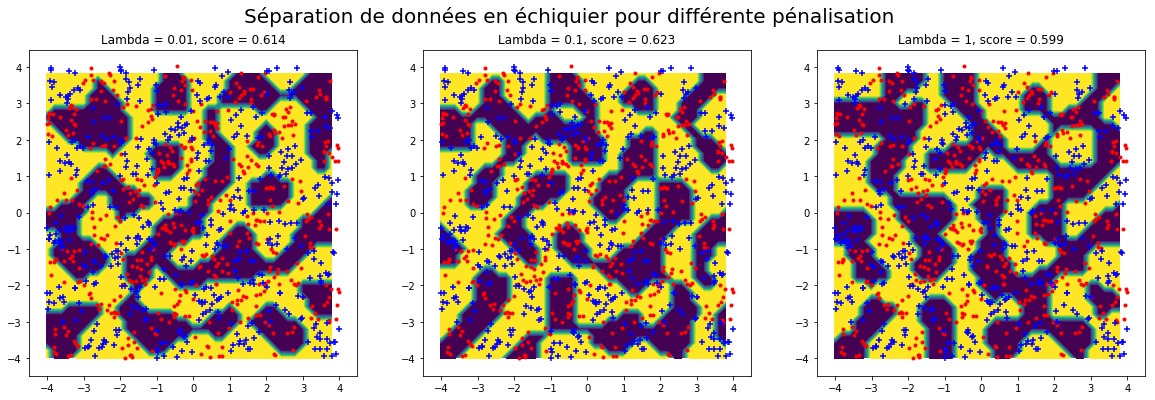

In [247]:
plt.figure(figsize= (20, 6))
plt.suptitle("Séparation de données en échiquier pour différente pénalisation", fontsize = 20)

plt.subplot(1, 3, 1)
plt.title("Lambda = 0.01, score = {}".format(P_L1.score(xtest, ytest)))
plot_frontiere(xtest, P_L1.predict)
plot_data(xtest, ytest)

plt.subplot(1, 3, 2)
plt.title("Lambda = 0.1, score = {}".format(P_L2.score(xtest, ytest)))
plot_frontiere(xtest, P_L2.predict)
plot_data(xtest, ytest)

plt.subplot(1, 3, 3)
plt.title("Lambda = 1, score = {}".format(P_L3.score(xtest, ytest)))
plot_frontiere(xtest, P_L3.predict)
plot_data(xtest, ytest)

plt.show()

<h2> Quel $\lambda$ est optimal ? </h2>

In [697]:
xtrain, ytrain = gen_arti(1, 2, 0.05, 1000, 2, 0.02)
xtest, ytest = gen_arti(1, 2, 0.05, 1000, 2, 0.02)

O = extract_random(xtrain, 300)
proj_random = lambda x : proj_gauss(x, sigma = 0.3, O_tab = O)

scores = []
lambdas = np.logspace(-7, 1, 10)
i=0
for l in lambdas:
    P = Perceptron_punish(bool_print= False, max_iter= 200, projection= proj_random, eps=0.1, lambd = l)
    P.fit(xtrain, ytrain) 
    scores.append(P.score(xtest, ytest))
    i+=1
    print(i)


1
2
3
4
5
6
7
8
9
10


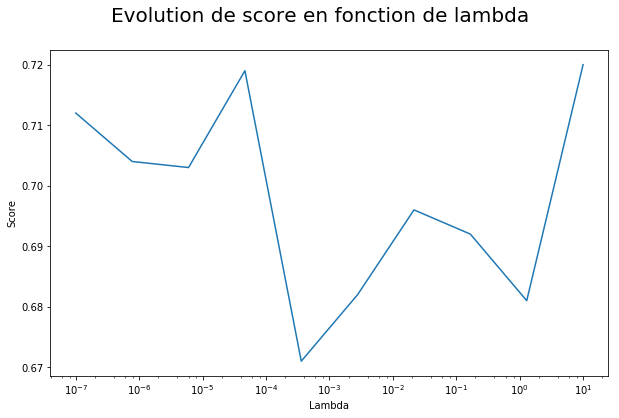

In [703]:
plt.figure(figsize = (10, 6))
plt.suptitle("Evolution de score en fonction de lambda", fontsize =20)
plt.plot(lambdas, scores)
plt.xlabel("Lambda")
plt.ylabel("Score")
plt.xscale('log')
plt.show()

<p> Pour ces données artificielles, la pénalisation ne semble pas avoir d'effet. </p>